<a href="https://colab.research.google.com/github/hariszaf/coi_dark_matter/blob/protein_level/dark_matter_on_coi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hariszaf/darn/main/figures/darn_logo.png" alt="drawing" width="200"/>

# Materials and methods for the Dark mAtteR iNvesigator (DARN) tool

### This notebook accompanies the manuscript: <br/> "*Bacteria are everywhere, even in your COI amplicon data!*"


# About this Google Collab file

Aim of this Google Collab notebook is to demonstrate 
how the COI reference tree was built and the main implementation steps
for building the `darn` tool.

`darn` is now available as a [Docker container](https://hub.docker.com/r/hariszaf/darn).

You may also find its source code on its [GitHub repo](https://github.com/hariszaf/darn).

The chunks of code with the following lines on top


```
#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
```

are scripts that were performed as **jobs** on the [Zorba cluster](https://hpc.hcmr.gr/) called ***sbatch*** files. 

The ```#SBATCH``` lines describe the resources asked from the cluster for each job, e.g. RAM, cores, nodes etc.

# Intro

To build `darn` we have to:

* get as many as possible COI sequences from all the 3 domains of life
* build consensus sequences for each domain conserving as much diversity of those as possible
* build a single tree for all the consensus sequences
* assign COI sequnce data from environmental samples on the tree 

The approach we used is thoroughly described at this [Full Stack Example](https://github.com/Pbdas/epa-ng/wiki/Full-Stack-Example) of the Evolutionary Placement Algorithn (`epa-ng`)! 

As you can see there, there are 5 steps to get the assignments of some query sequences to a tree. 

>**Step 1:**  *Selecting the reference sequences*

For this step, we had: 
* the Midori v2 database for the domain of Eukaryotes
* all the COI related sequences from BOLD for the case of Archaea and Bacteria 

>**Step 2:**  *Building a reference alignment and tree*

For this step, as the scale of our analysis was way too big for a straightforward approach, we had some inne steps. 

The main concept was to keep as much of the diversity of each domain in a number of sequences able to proceed with. 

We used the `mafft` algorithm to get the alignments (multiple implementations were performed to address the challenges of each domain). 

And then we use the `phat` algorithm to get consnensus sequences from each domain (for the Eykaryotes and Bacteria cases)> 


**KEEP IN MIND**
the eukaryotic sequences that will be used in this step, will be an order of magnitude more than those of Bacteria.


>**Step 3:**  *Aligning the query sequences*

As suggested in this example, we used the `papara` tool align the query sequences of ours, against the refence MSA we buit in step 2.



>**Step 4:**  *Placing the query sequences*


Here we final implement what we wanted in the first place. 

We assign sets of query sequencies to our reference tree, to see whether our so-called "eukaryotic" sequences are actually such or not.. 


>**Step 5:**  *Visualization, post-analysis*

There are many options for this step. 

We will consised iTOL as well as more sophisticated algorithms for this task, such as `gappa` and `scrapp`

# Sequences from the Life domains

## Eukaryotes

For the case of COI the [Midori 2](https://academic.oup.com/bioinformatics/article/34/21/3753/5033384) database was used; specifically the MIDORI_UNIQ_GB239_CO1_RDP version including not only metazoa but sequnecess covering a wide range of eukaryotic taxa.

Here is its corresponding [website](http://www.reference-midori.info/) from where you can get the README file.

As mentioned in the README file of the Midori 2, there is a number after taxonomy each taxonomy level, representing the corresponding GenBank Taxonomy ID. 

As an example, here is the header of a Midori 2 sequence:
```
>MG559732.1.<1.>690	root_1;Eukaryota_2759;Discosea_555280;Flabellinia_1485085;order_Vannellidae_95227;Vannellidae_95227;Clydonella_218657;Clydonella sawyeri_2201168
```
This information is rather usefull, however we need to remove it for our analysis. 

To do so, we ran the following sed commands:

In [ ]:
sed 's/.1.<1.>[0-9]*//g; s/_[0-9]*//g' MIDORI_UNIQ_GB239_CO1_RDP.fasta > MIDORI_UNIQ_GB239_CO1_RDP_no_taxids.fasta

In addition, as Midori 2 includes more than one sequences for a species in many cases, we need to keep only one. To do so, we used the [`clear_the_doubles.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/clear_the_doubles.py) script. 

And then we ran the following sed command to get rid of the ```root;``` prefix in the taxonomies.

In [ ]:
sed -i 's/root;//g' MIDORI_single_species_input_for_PHAT_algo.fasta 

After that, we end up with **183.330 sequences** while the initial number of this Midori 2 version is **1.315.378**. 

These sequences are now our Eukaryotes COI dataset and need to get aligned. That is a huge task from a computanional point of view! 
 

So, in terms of getting the alignment, a straightforward alignment is not possible. 

A ***core set*** of 500 sequences was used to build an alignment which was later used to align all the rest using this first as a base. 

**Attention!**
As our sequences are from a reference database, we assume that are all of the same quailty.

To figure out what sequences to use for the core set we need to find the longest ones from each phylum. 


Here is the number of sequences for each phylum and the number of the **longest** sequences we got to build the *core set*.

| Phylum | # of occurences |  # of seqs in core aln |
|:------:|:--------------------:|:--------------------:|
| Acanthocephala | 134 | 4 |
| Annelida | 2.870 | 16 |
| Apicomplexa | 356 | 4 |
| Arthropoda | 124.082 | 147 |
| Ascomycota | 587 | 4 |
| Bacillariophyta | 185 | 4 |
| Basidiomycota | 282 | 4 |
| Blastocladiomycota | 3 | 1 |
| Brachiopoda | 36 | 2 |
| Bryozoa | 215 | 4 |
| Cercozoa | 3 | 1 |
| Chaetognatha | 36 | 2 |
| Chlorophyta | 145 | 4 |
| Chordata | 29.157 | 97 |
| Chytridiomycota | 7 | 1 |
| Ciliophora | 218 | 4 |
| Cnidaria | 1.774 | 16 |
| Cryptomycota | 1 | 1 |
| Ctenophora | 19 | 2 |
| Cycliophora | 2 | 1 |
| Dicyemida | 12 | 2 |
| Discosea | 64 | 2 |
| Echinodermata | 1.541 | 16 |
| Endomyxa | 2 | 1 |
| Entoprocta | 17 | 2 |
| Euglenozoa | 60 | 2 |
| Evosea | 11 | 2 |
| Gastrotricha | 62 | 2 |
| Gnathostomulida | 9 | 1 |
| Haptista | 18 | 2 |
| Hemichordata | 9 | 1 |
| Heterolobosea | 23 | 2 |
| Imbricatea | 8 | 1 |
| Kinorhyncha | 32 | 2 |
| Mollusca | 11.980 | 48 |
| Mucoromycota | 71 | 2 |
| Nematoda | 1.413 | 16 |
| Nematomorpha | 22 | 2 |
| Nemertea | 250 | 4 |
| Onychophora | 85 | 2 |
| Perkinsozoa | 2 | 1 |
| Phoronida | 12 | 2 |
| Placozoa | 2 | 1 |
| Platyhelminthes | 1.535 | 16 |
| Porifera | 813 | 4 |
| Priapulida | 4 | 1 |
| Rhodophyta | 1.741 | 16 |
| Rotifera | 228 | 4 |
| Streptophyta | 1.595 | 16 |
| Tardigrada | 136 | 4 |
| Tubulinea | 1 | 1 |
| Xenacoelomorpha | 81 | 2 |
| Zoopagomycota | 3 | 1 |



 The [`keep_longest_single_line_seqs.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/keep_longest_single_line_seqs.py) script was build to return the $n$ longest sequences from each phylum from the `MIDORI_single_species_input_for_mafft.fasta` file.

Once we have the *core set* sequences, we need to remove them from the `MIDORI_single_species_input_for_mafft.fasta` file.

To do this we performed the [`get_the_non_core_seqs.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/get_the_non_core_seqs.py) script.


Now we are able to perform the two-steps alignment as suggested from the mafft-team (see Extras).

[Here](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/mafft_two_steps_job.sh) is the sbatch script we used for this step. 

And here is what we get!! 

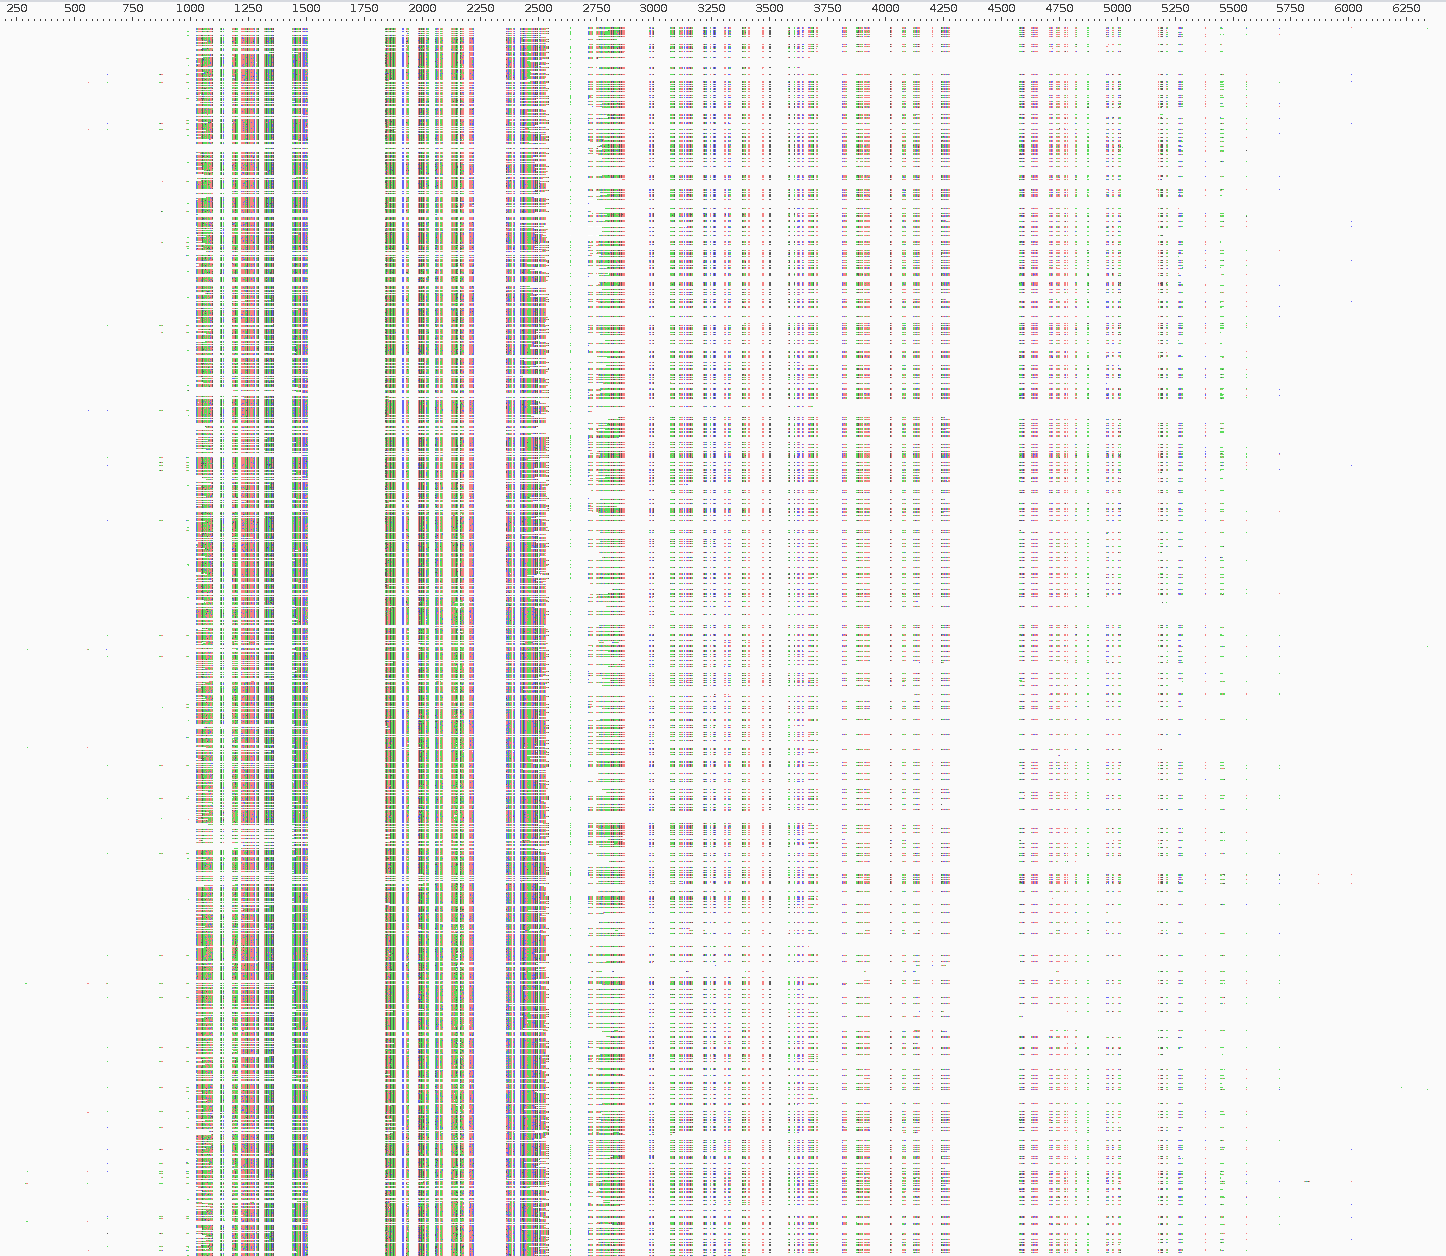

Now we just replace the last space in the taxonomy of each sequence with an underscore ("_") so Phat can take is as input. 

```
sed -i -E 's/(.*)\s/\1_/' full_midori_alignment.aln > full_midori_alignment_underscore.aln 
```

and we keep the taxonomies in a seperate file too. 

```
awk -F "\t" '{if ($0 ~ />/ ) {print $2}}' full_midori_alignment_no_taxon_levels.aln 
```



and we are ready to go for the Phat step.

However, **keep in mind** that for using PhAT: 

* your .fasta file needs to have only a single ` ` (space) between the id and its taxonomy
* if your taxonomy has and spaces or tabs, then it will be broken 
* all taxonomies in your `taxonomy-file` need to be present in the `sequence-file` so it is always a good practice to build your `sequence-file` and then extract the taxonomies from that



[Here](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/phat_job_eukaryotes.sh) is the `sbatch` script used to run `phat` for the case of eukaryotes. 



To get the consensus sequences for the case of eukaryotes was rather challenging from the computational point of view as more than more than 180,000 
unique species were included.



---------------------------------------------

## Bacteria & Archaea

Two ways for getting COI sequences were followed: 
* dna sequences were directly retrieved through the API of the BOLD database
* through the PFam id for COI, protein sequences were found and from there the coordinates to the corresponding genomes were extracted. Finally, dna sequences from these genome parts were retrieved. 

With resepct to method (1), the exact same steps followed in the case of bacteria, were also followed for archaea.


In addition, when method (2) was ran, sequences from both bacteria and archaea were retrieved. 

Therefore, we will discuss bacteria- and archaea-relates steps at the same time. All the hyperlinks point to the bacteria-related scripts.

### **DNA COI sequnces from BOLD**

To get the bacteria and archaea COI sequences we used the [BOLD API](https://v3.boldsystems.org/index.php/resources/api).

From [Silva database browser](https://www.arb-silva.de/browser/) we got the list of phyla of interest and searched for those in BOLD.

By running the following command for the various phyle, a `.xml` file was retrieved for each of those present in BOLD, in this example Proteobacteria. 

In [ ]:
TAXON="Proteobacteria"
curl -o Proteobacteria http://v3.boldsystems.org/index.php/API_Public/combined?taxon=$TAXO

To get the info needed we had to parse these `.xml` files. 

To this end, we developed the [`parse_xml_files.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/parse_xml_files.py) which builds the `ncbi_ids_and_seq.tsv` file. 

From this file we keep the ncbi taxonomy ids and the phylum of each sequence in a file called `ids`.

In [ ]:
awk '{print $1"\t"$2 }' ncbi_ids_and_seq.tsv > ids
awk -F "\t" '{print $1}' ids > ncbi_ids

We make a precursor `.fasta` file keeping just the ncbi taxonomy id as a title and its corresponding sequence.

In [ ]:
sed 's/^/>/' ncbi_ids_and_seq.tsv | sed 's/\(.*\)\t/\1\n/' | sed 's/\t.*//' > ncbi_ids_and_seq.fasta

In the following chuncks of code the corresponding NCBI ids and the complete taxonomies are completed. To do so, under `ncbi_new_taxdump` directory you need to add the NCBI dump files you may find under the [FTP of the NCBI taxonomy database](https://ftp.ncbi.nih.gov/pub/taxonomy/).

In [ ]:
while read TAX_ID;  
do
    awk -v var=$TAX_ID '$1==var' /home1/haris/Desktop/ncbi_taxonomy_dump/fullnamelineage.dmp | awk -v var=$TAX_ID -F "|" '{print var "\t" $3 " " $2}' ;  
done < ncbi_ids > temp.taxonomy

and then..

In [ ]:
sed -i 's/; /;/g ; s/cellular organisms;//g' temp.taxonomy
sed -i 's/;[[:blank:]]\+/;/g ; s/ /_/g' temp.taxonomy

Once the taxonomy file was ready, the [`get_full_taxonomies.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/get_full_taxonomies.awk) script was performed to build the complete `.fasta` file. 

And in order to make the output file a multiline fasta.

In [ ]:
sed '/^>/!s/.\{80\}/&\n/g' bold_bacteria_full_taxonomy_seq.fasta > multiline_bold_bacteria_full_taxonomy_seq.fasta 

Likewise, we did the same for the case of Archaea. 
From BOLD we managed to get 



| Domain | # of seqs | # of unique families | 
|:----:|:-----:|:-----:|
| Bacteria | 3,857 | 218 | 
| Archaea | 127 | 13 |


---------------------------------------

### **Protein sequences from PFam - mapping to their DNA records**

After search the PFam database, the loci of our interest COX1 was identified as the family [PF00115](http://pfam.xfam.org/family/PF00115). 

All the 16,128 protein sequnces of the family, coming from **5,706** species, were downloaded and their ids were kept. 


In this case, we will see what sequences come from bacteria, archaea and eukaryotes, once we have their full taxonomies.


In [ ]:
# parse and keep the ids
cat PF00115_full.txt | grep ">" | awk -F "_" '{print $1}' | sed 's/>//g' > uniprot_ids.tsv

# split the ids to files of 200 entries on the ids/ directory
split -l 200 uniprot_ids.tsv

To get the DNA sequences that correspond to the proteins retrieved, the coordinates of the sequences in the corresponding genomes are needed. 

To get them, the [`get_coordinates.sh`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/get_coordinates.sh) was built.

Once the coordinates and the corresponding genomes ids have been extracted, the DNA sequences of interest can be retrieved.

To do so, the unique entries were kept and the coordinate were isolated.

In [ ]:
sed 's/\/coded_by="complement(//g ; s/\/coded_by="//g ; s/)"//g ; s/"//g' coordinates.tsv > tmp

more tmp | sort | uniq | sort > tmp2
mv tmp2 coordinates.tsv 

sed -i 's/<//g ; s/>//g ; s/join(//g' coordinates.tsv 
mkdir coordinates 
cp coordinates.tsv coordinates/
split -l 200 coordinates.tsv
rm coordinates.tsv

As Midori's longest sequence was at 1992bp and most of its sequences were less than 1600bp long, a sequence length threshold for the COI derived from the PFam related DNA sequences was set at 1800bp.

To finally, get the DNA sequences the [`get_dna_seq.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/get_dna_seq.py) script was built and performed.


In addition, the NCBI id and the full taxonomy for each sequence were needed in this case too. 

So,we used the 
`nucl_gb.accession2taxid` and the
`nucl_wgs.accession2taxid` files
from the [NCBI Taxonomy FTP server](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/). 


From the `downloads.log` file, we can keep the accession numbers needed for the mapping. 
To do so, we run

In [ ]:
sed 's/\..*//g' downloads.log  > accessions

And now, using the [`get_full_taxonomies.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/get_full_taxonomies.awk) scirpt we were able to do the mapping between a NCBI id and its complete taxonomy. 

For example, 

```
2320083   Bacteria;Terrabacteria_group;Firmicutes;Clostridia;Eubacteriales;Clostridiaceae;Butyricicoccus;unclassified_Butyricicoccus;Butyricicoccus_sp._1XD8-22
```

As an accession number comes from a gene entry or from a genome one, we run the same script against those 2 mapping files and then we concatenate their findings.

In [ ]:
cat PAIRS_wgs PAIRS_gb > PAIRS

Finally, using the [`build_seq_file.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/build_seq_file.awk) the .fasta file with both the NCBI id, the accession number and the sequence, is ready.

Some modifications are thus needed.

In [ ]:
sed -i 's/; /;/g ; s/cellular organisms;//g' IDS_TAXA
sed -i 's/;[[:blank:]]\+/;/g ; s/ /_/g' IDS_TAXA

Stats for PFam

| Domain | # of seqs | # of unique families | 
|:----:|:-----:|:-----:|
| Bacteria | 9,154 | 358 | 
| Archaea | 217 | 12 |


### Concatenate sequences from BOLD and PFam related

**Highlight!!**
In some few cases, we found strains of the same genus having the exact same COI sequence! 

For example 
*Sulfolobus_acidocaldarius_DSM_639* 
* *
* *

#### Bacteria

When the .fasta files with the sequences retrieved from the 2 databases were concatenated, the merged file included 13,027 sequences. 

However, the unique sequences found were 11,420. 

Up to now, using PFam derived sequences improved our dataset since from the
3,859 sequences originally retrieved from BOLD, have increased 3-fold. 

However, to check what is the true benefit of adding PFam oriented sequences in our dataset, we need to check the taxa that they correspond to and see if taxa that were not included before (in the BOLD dataset), are now present in our amended dataset. 

Using only BOLD, the 3,859 sequences that were retrieved, represented **3,859** unique NCBI Taxonomy Ids.

The unique NCBI Taxonomy Ids from both BOLD and PFam seqences are **6,228**.

This proves that adding sequences found in PFam, adds an important number of taxa in the amended dataset. 

However, to check its true value we also have to: 
* check the higher taxonomy of the new taxa (i.e. how many new genera, families, orders etc have been added with the inclusion of the new sequences)
*check the alignment of the 11,420 sequences to identify potential gaps and mismatches between the two datasets (BOLD and PFam). 

In the initial **BOLD dataset**, we had sequences from **218** bacterial families.

In the **amended dataset**, we have now sequences covering **375 families**; while indicatively, the bacterial families present in [Genome Taxonomy Database](https://gtdb.ecogenomic.org/stats/r202) are currently **2,886**.

That means, 157 families were added using information from **PFam**.

| Source | # of unique seqs | # of unique families | 
|:----:|:-----:|:-----:|
| BOLD | 2,267 | 220 | 
| PFam-oriented | 9,153 | 353 |
| altogether | 11,420 | 375 |

As mentioned, the 11,420 sequences however, are from a set of 6,228 unique NCBI Taxonomy IDs

Here is the sequence alignment of the BOLD COI Bacteria sequences using the script [`mafft_job_orientation.sh`](https://github.com/hariszaf/coi_dark_matter/blob/master/sequences_of_life/bacteria/mafft_job_orientation.sh).

--------------------------------------------------------------------------------------------

### Archaea


| Source | # of unique seqs | # of unique families | 
|:----:|:-----:|:-----:|
| BOLD | 107 | 13 | 
| PFam-oriented | 217 | 12 |
| altogether | 323 | 15 |



| Family      | BOLD | PFam     |
| :---        |    :----:   |          ---: |
| Archaeoglobaceae |  &#9744; | &#9745; | 
| Desulfurococcaceae | &#9745; | &#9745; |
| Ferroplasmaceae | &#9745; | &#9744; |
| Haloarculaceae | &#9745; | &#9745; |
| Halobacteriaceae | &#9745; | &#9745; |
| Halococcaceae | &#9745; | &#9745; |
| Haloferacaceae | &#9745; | &#9745; |
| Halorubraceae | &#9745; | &#9745; |
| Methanoperedenaceae | &#9744; | &#9745; |
| Natrialbaceae | &#9745; | &#9745; |
| Nitrosopumilaceae | &#9745; | &#9745; |
| Nitrososphaeraceae | &#9745; | &#9745; |
| Picrophilaceae | &#9745; | &#9744; |
| Sulfolobaceae | &#9745; | &#9745; |
| Thermoproteaceae | &#9745; | &#9744; |


# Build the phylogenetic tree

After getting the consensus sequences for all the three domains of life, we need to build a single MSA for all the sequences derived. 

To do this, we need to remove all the "-" from the sequences in the alignment of each domain and then build our final MSA using the total number of these sequences. 

This is final MSA is the one we will use to build our magic tree.



To this end, we first concatenate all the consensus sequences to a single file.

In [ ]:
 cat consensus_sequences_archaea.fasta consensus_sequences_100_order_level.fasta consensus_sequences_min_tax_level_3.fasta > all_consensus_initially.fasta

To remove the "-" spots from a PhAT alignment, we need to run the following simple ```sed``` commands. 

In [ ]:
sed 's/-//g ; /^$/d' all_consensus_initially.fasta > tmp.fasta

And then run the following `awk` and `sed` commands:

In [ ]:
awk  'BEGIN { RS = ">" } { ORS=" " };{print "\n"">"$1"\n"}; {for(i=2;i<=NF;++i) print $i}' tmp.fasta > tmp_single_line.fasta
sed -i 's/ //g' tmp_single_line.fasta
awk 'BEGIN { RS = ">" } !/^\s*$/ {print ">"$0}' tmp_single_line.fasta > dev.ouput    # where dev.output has the exact same information as the one from Script No 13 but it is in single line FASTA format. 

for all the 3 consensus fasta files. 

Once we do that, then we may run one more mafft job (this will not take long) to get our final MSA with the reference sequences. 


In [ ]:
#!/bin/bash
## Script name: msa_for_consensus_of_life.sh

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="consensus_msa"
#SBATCH --output=consensus_msa.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


# Load the mafft module on the Zorbas HPC system and start time 
module purge # unloads all previous loads
module load mafft/7.453
start=$SECONDS


# Run the mafft alignment tool
/usr/bin/mafft --globalpair --maxiterate 1000 --thread 20 consensus_sequences/all_consensus_mafft_input.fasta >  all_consensus_aligned.fasta


# Stop counting the time and unload the environment module 
duration=$(( SECONDS - start ))
echo "duration is : $duration  "
module unload mafft/7.453 #unloads mafft



So here is the alignment for the consensus sequences retrieved using the BOLD 



database to get COI sequences for Bacteria and Archaea.

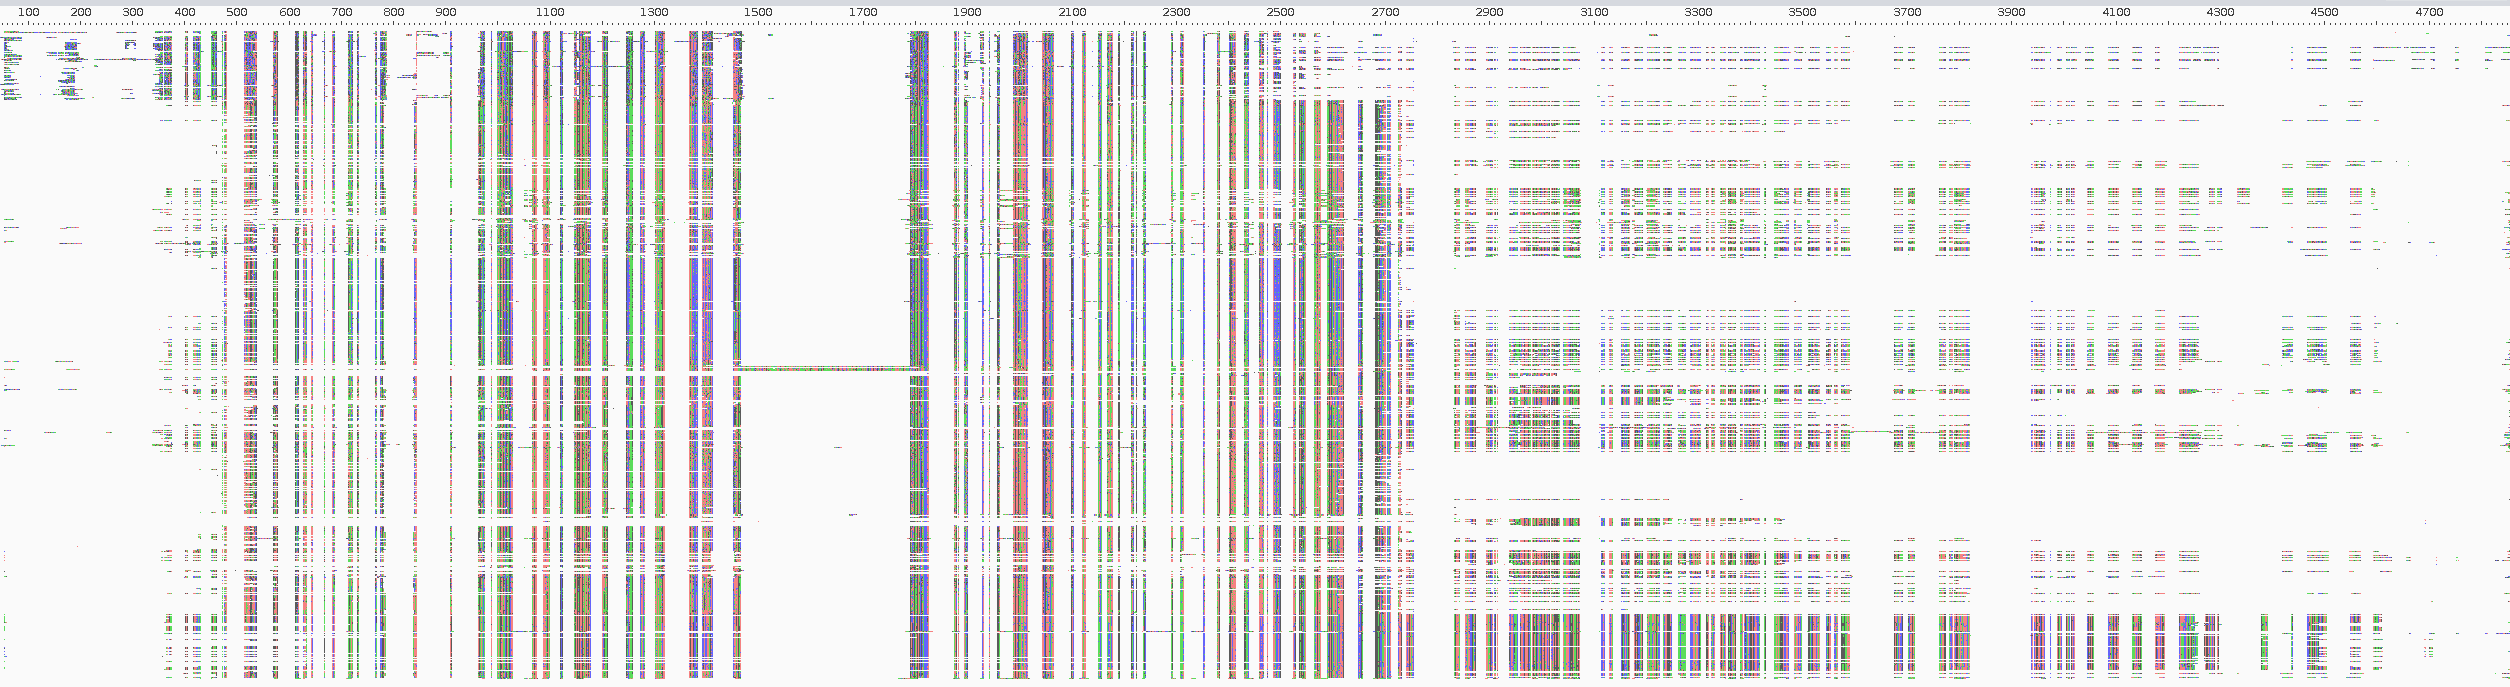

We then used [`ClipKIT`](https://jlsteenwyk.com/ClipKIT/advanced/index.html) to trim our MSA. 

--------------------------------------

Once the MSA was completed, we tried to run the raxml-ng test script to tell us whether ous MSA is good to run on the raxml-ng. 

First, we need to check whether our MSA is proper to do so, so we ran:

In [ ]:
# 1
raxml-ng --check --msa all_consensus_aligned.fasta --model GTR

# 2
raxml-ng --parse --msa prim.fasta --model GTR+G

# 3
/home1/haris/programs/raxml-ng/raxml-ng/bin/raxml-ng-mpi \
--search1 \
--msa parse_test.raxml.rba \
--model GTR+FO+G4m \       # can be ignored as the .rba file includes the model - the .rba was build by the raxml-ng --parse command
--seed 1 \
--prefix search1_bold
--threads 8


#4
/home1/haris/programs/raxml-ng/raxml-ng/bin/raxml-ng-mpi \
--bootstrap \
--msa parse_test.raxml.rba \
--model GTR+FO+G4m \
--prefix BS_TEST \
--seed 2 \
--threads 3


And we ran into a new issue, as in raxml we need to have unique taxonomy names.
As it was only for the case of a single Archaea species, we fixed that manually by adding an index to each of the two sequences.

Then we ran this again to get a warning this time.
We had 2 pairs of sequences on our data that are completely identntical! 

The one was the 2 Archaea *Halorubrum halodurans* sequences, so we removed the one copy.

The other one, interestingly were 2 bacteria sequences, one assigned as 

`Bacteria_FCB_group_candidate_division_Zixibacteria_unclassified_candidate_division_Zixibacteria_candidate_division_Zixibacteria_bacterium` 

and the oter as 

`Bacteria_Proteobacteria_Gammaproteobacteria_Xanthomonadales `

we decided to keep the second one as the first is full with `unclassified` and `candidate`



Then we ran again the building the tree job.

In [ ]:
#!/bin/bash 

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="magic_tree"
#SBATCH --output=magic_tree.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


# 4 sequences were removed after the check 
/home1/haris/metabar_pipeline/PEMA/tools/raxml-ng/raxml-ng/bin/raxml-ng --all \
--msa-format FASTA \
--msa all_consensus_aligned3__removed.fasta \
--tree pars{10} \
--bs-trees 10 \
--model GTR+FO+G4m \       # that was set like this following the suggestion of the raxml-ng check
--threads 3


# if tree is ok, then you can try to ask for more bootstraps for a more reliable tree
# --bs-trees 100
#   GTR+G4

Now, let us have a look on the output of the raxml-ng.

* **startTree** :
* **bestTree** :
* **bestModel**:
* **log** :
* **ckp** :


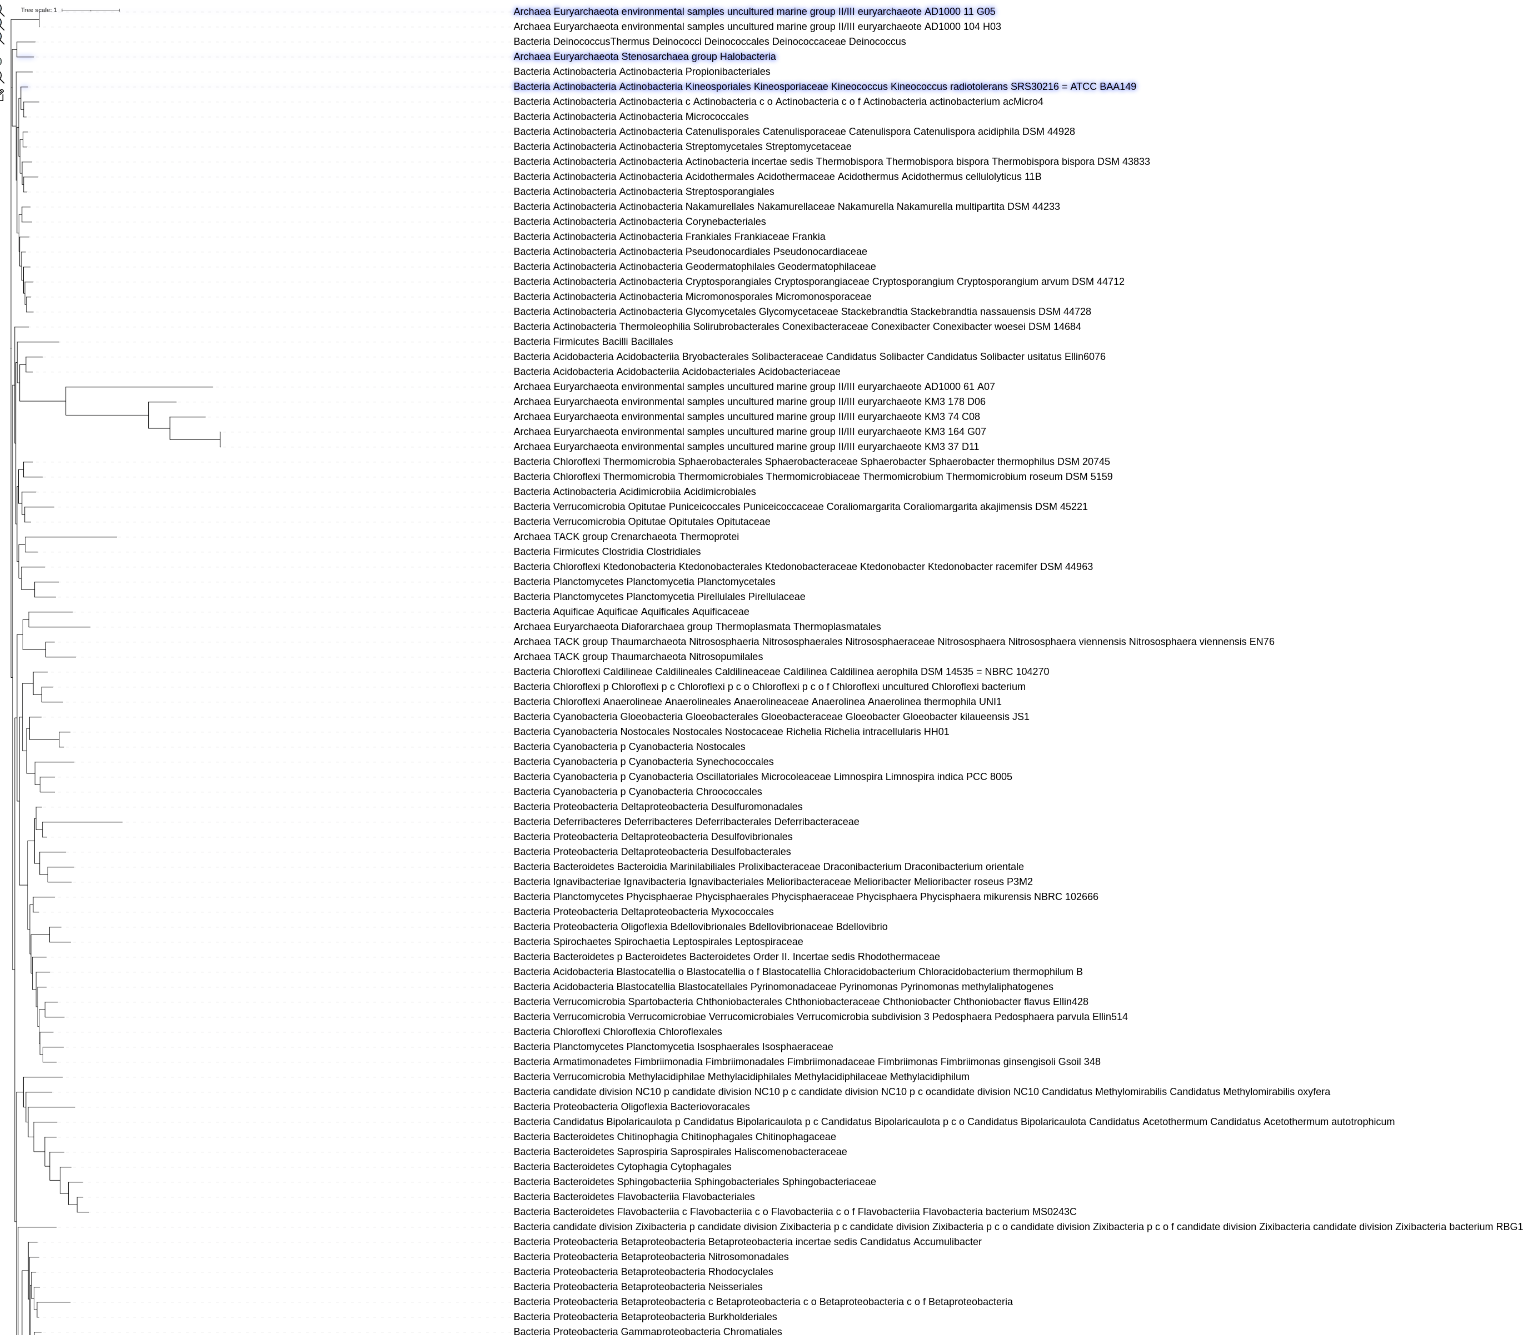

Here are some statistics regarding the final tree contentes: 


**Eukaryotes**

| Phylum | # of consensus sequences </br> on the tree| 
|:----:|:----:|
| Chordata | 197 | 
| Streptophyta | 107 | 
| Rhodophyta | 33 | 
| Porifera | 28 | 
| Platyhelminthes | 49 | 
| Mollusca | 118 | 
| Echinodermata | 34 | 
| Platyhelminthes | 49 | 


asdasd

| Small Eukaryotes Phylum | # of consensus sequences </br> on the tree| 
|:----:|:----:|
| asda|asda |  

It is worth-mentioning that 98 of the Chordata sequences, i.e 50% of them, come from Actinopteri

# Assigning the COI dark matter on the magic tree


Once the tree is ready, there is only one thing left to do. We need to assign query sequences, i.e sequences coming from COI from environmental samples, the taxonomy of whom has not been verified. 

To do this, we need to build a new MSA, **based on** the one we already have from the consensus sequences. We *concatenate* the query sequences on the initial MSA to build a new one, using the `papara` algorithm. 

Once this is done, we use the evolutionary placement algorithm, `epa-ng`, to make the assignment. 


Finally, we need a visualization tool, to allow us to see the actual placements of our query sequences on the magic tree. 


## a second MSA: consensus + queries

As already mentioned, we used the `PaPaRa` algorithm.

Before of that, we have to make our queries in a format `PaPaRa` supports, meaning multiline fasta.

In [ ]:
# to relabel the Otus on the multiline fasta
awk -v n=1 '{if($x~/>/){sub(/>.*/, ">Otu" n); print; n++}else{print $0}}' marine_query_short_dark_matter_top6_multilne.fasta > \ 
marine_query_short_dark_matter_top6_multilne_labeled.fasta

# to convert single line fasta to multi line
sed '/^>/!s/.\{80\}/&\n/g' marine_query_short_dark_matter_top6.fasta > marine_query_short_dark_matter_top6_multilne.fasta


Now we are ready to go for the `PaPaRa` step.

In [ ]:
## Script No 19: papara_step.sh

#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="papara"
#SBATCH --output=papara.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


/home1/haris/Desktop/test_papara/papara_nt/papara \
-t /home1/haris/Desktop/test_papara/dark_coi/bestML_tree.tree \
-s /home1/haris/Desktop/test_papara/dark_coi/all_consensus_aligned.fasta.phylip \
-n TEST_papara_final \
-q /home1/haris/Desktop/test_papara/dark_coi/marine_query_short_dark_matter_top6_multilne_labeled.fasta \
-r \
-j 12


# NOTE
# I installed PaPaRa from source (not as static binary) to enable multithreading (-j parameter)
# To do so, follow instructions here: https://cme.h-its.org/exelixis/web/software/papara/index.html

# Pay attention in the following:
# If the sub-directory papara_nt-master/ivy_mike/ is empty, also download
# https://github.com/sim82/ivy_mike/tree/3269b7b39dc6c129cfe72708d9086f1e8f8c2c98

# I ran 
# git clone https://github.com/sim82/ivy_mike/tree/3269b7b39dc6c129cfe72708d9086f1e8f8c2c98
# and then I moved the ivy_mike in the papara_nt directory to replace the empty directory there

From the [Full Stack Example](https://github.com/Pbdas/epa-ng/wiki/Full-Stack-Example)

*Note the* `-r` *option: this is vital to ensure comparability between different query files for the same reference tree, as it forces papara not to add any sites to the original reference alignment!*

*Next, before the actual placement can commence, we need to explicitly prepare the input, as epa-ng (currently) only accepts separate query and reference alignment files, both in fasta (or bfast) format. Papara, for example, outputs the aligned queries together with the reference MSA, in phylip format.*

*This can be done directly with epa-ng now, using the* `--split` *function:*

`epa-ng --split ref_alignment query_alignments+*`

> **epa-ng takes only `.fasta` files as input!**

from PHYLIP to FASTA 

```bash=
awk '{print ">"$0}' my_input.phy > tmp
sed 's/ \{1,\}/ /g ; s/ /\n/' tmp > tmp2
sed '/^>/!s/.\{80\}/&\n/g' tmp2 >  my_input.fasta
```

## Placing query sequences on the magic tree

Once we have this second MSA, we are now ready to go for the last step of our analysis. The assignment of the queries sequences on the magic tree of life.

In [ ]:
#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
### SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="epa-ng"
#SBATCH --output=assignment.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue

/home1/haris/metabar_pipeline/tools/epa/bin/epa-ng \
-s result.fasta \
-t all_together_aligned_final.fasta.raxml.bestTree \
-q queries.fasta \
--threads 20 \
--model GTR{1.68433/3.87469/4.75022/2.48197/8.99014/1}+FU{0.2557/0.177709/0.176786/0.389804}+G4m{0.699268}


/home1/haris/metabar_pipeline/PEMA/tools/epa/bin/epa-ng -t bestML_tree.tree -s ref_msa.phy -q qs_msa.phy -m GTR+FO+G4m


# Extras


## Key notes from the mafft team


According to the title lines, the sequences are from a wide range of eukaryotes, animals, plants and so-colled protists. The sequences might be homoloous but they are considerably **diverged**. In such a case, the MSA of the full data (183.420 sequences) would be unpractically long, because ***different sequences have gaps at different positions***. Also, sequences are not fully reliable and long artificial insertions could exist. This factor also makes the MSA very long. 

To avoid this problem, I suggest a two-step procedure, ie, (1) select and align reference sequences and then (2) add the others. 

---------------------------------------------------------------

Step-by-step procedure is:

0. Select a small number (~10 - ~500) of representative sequences, as a **reference set**, to cover **representative taxonomic groups** and contain **only reliable sequences**.

1. Align the reference set.
```
% mafft --auto --reorder references > referencealignment
```

2. Align the other sequences to the reference alignment,
```
% mafft --thread 60 --auto --addfull othersequences --keeplength --reorder referencealignment > fullalignmentImportantly
``` 
the ```--keeplength``` option inserts gaps asymmetrically. 
See the figure [here](https://mafft.cbrc.jp/alignment/software/addsequences.html#fragments).
When an insertion is found in one of the non-reference sequences, the insertion is just removed, unlike normal alignment calculation. As a result, the length of MSA is the same as that of the reference alignment.

3. Run PhatIntermediate results of my test run are:

---------------------------------

**Step 1 (reference alignment consisting of 90 sequences):** https://mafft.cbrc.jp/alignment/test/midori/referencealignment

**Step 2 (full alignment consisting of 183420 sequences):** https://mafft.cbrc.jp/alignment/test/midori/fullalignmentwhere 

I randomly selected the references and then manually refined the selection so that the reference sequences have similar lengths (~full length of this gene probably). They are marked marked as "REF|" in title line. 
All bases of these reference sequences are included in the two MSAs above. As to other sequences, only the bases that correspond to any base in the reference alignment are included in the fullalignment.

Does Phat work this full alignment?

Step 2 took just several minutes using less than 10GB RAM / 8 cores. After you confirm the this procedure works well, it's better to use codon-based alignment by MACSE or other tools, instead of MAFFT, for step 1.

### mafft with mpi

To get the alignment of the MIDORI unique species sequences, we run a mafft job like in the case of Bacteria. Here it is: 


In [ ]:
## Script No 11: maff## Script No 3: download_summaries.py - esummary

#!/usr/bin/python3.5t_job_midori.sh

#!/bin/bash

#SBATCH -N 2
#SBATCH -B 2:10:1
#SBATCH --partition=batch

#SBATCH --ntasks-per-node=15
#SBATCH --cpus-per-task=1
#SBATCH --hint=compute_bound
#SBATCH --job-name="mpialt"

#SBATCH --output=mafft-midori-fast.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue

export MAFFT_N_THREADS_PER_PROCESS="1"
export MAFFT_MPIRUN="/usr/bin/mpirun -n 30 -npernode 15 -bind-to none"


export MAFFT_N_THREADS_PER_PROCESS="1"
export MAFFT_MPIRUN="/usr/bin/mpirun -n 30 -npernode 15 -bind-to none"

/mnt/big/Tools/mafft-7.453-with-extensions/bin/mafft \
--mpi \
--large \
--globalpair \
--thread 15 \
MIDORI_single_species_input_for_mafft.fasta > \
MIDORI_alignment.fasta


The trick here, is that we use more than one node of our cluster, i.e we run in a parallel mode. That is possible thanks to the ```mpi``` implementation of the mafft algorithm! That is not trivial neither for the developer nor for the user, as each mpi-oriented algorithm has a different architecture that you need to understand in order to run it properly. 

**MAFTT Hints**

Here are two ways for using mafft for large datasets:
* [mpi](https://mafft.cbrc.jp/alignment/software/mpi.html) version of high-accuracy progressive options, [GLE]-large-INS-1
* [sparsecore](https://mafft.cbrc.jp/alignment/software/sparsecore.html) - using a core alignment of a subset of the dataset

Just like in the case of Bacteria, we also need a file with the taxonomies included in our MSA in order to run the PhAT algorithm. To get these taxonomies we ran:  

In [ ]:
cat MIDORI_single_species_input_for_mafft.fasta | grep ">" | awk -F "\t" '{print $2}' | sed 's/ /_/g' > midori_unique_taxonomies.tsv

As in Bacteria, we may have different approaches for using the PhAT algorithm in our sequences.

In [ ]:
## Script No 12: phat_job_eukaryotes.sh

#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --job-name="phat"
#SBATCH --output=phat.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue

# Running PhAT asking for 1000 consensus sequences (by default)
/home1/haris/Desktop/stsm/sequences_of_life/gappa/bin/gappa prepare phat \ 
--taxonomy-file second_attempt/taxonomies_of_the_final_seqs_with_species.txt \
--sequence-file second_attempt/final_alignment_for_eukaryotes_with_species.fasta \
--target-size 1000 \
--threads 20 \
--consensus-method majorities \
--out-dir second_attempt/phat_final_alignment

# Setting the order level as min-tax-tevel
/home1/haris/Desktop/stsm/sequences_of_life/gappa/bin/gappa prepare phat 
--taxonomy-file second_attempt/taxonomies_of_the_final_seqs_with_species.txt \
--sequence-file second_attempt/final_alignment_for_eukaryotes_with_species.fasta \
--target-size 1000 \
--min-tax-level 3 \
--threads 20 \
--consensus-method majorities \
--out-dir second_attempt/phat_final_alignment



More of **[mafft hints](https://mafft.cbrc.jp/alignment/software/addsequences.html#fragments)** !

## First and extra attempts to get sequence data

The following chuncks of code were performed as initial steps for this project but their outcome was not used in the `darn` software. However, as they did return us valuable insight on the COI publicly available sequences we archive them here. 

Moreover, scripts based on the following, can be used in the future to get further COI sequences. 

### Bacteria

In [ ]:
#!/usr/bin/python3.5
## Script name: get_webenv.py - esearch

# Bacteria
import requests
import re

db = "nucleotide"

# In the following query we describe what sequences we need to get. Filters allow to get exactly what we need from the NCBI database
query = "Coi[All Fields] OR Cytochrome c oxidase subunit I[All+Fields] OR CO1[All Fields] AND (Bacteria[Organism] OR Bacteria Latreille+et+al. 1825[Organism]) AND (1[SLEN]:2000[SLEN])) AND (bacteria[filter])"

# Get the WebEnv code - this is different every time you run this; thus we keep in a text file and then feed it accordingly in a next command
base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
url = base + "esearch.fcgi?db=" + db + "&term=" + query + "&usehistory=y"
response = requests.get(url)

# Yyou may find the WebEnv value returned from the query we asked 
print(response.text)


<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSearchResult PUBLIC "-//NLM//DTD esearch 20060628//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20060628/esearch.dtd">
<eSearchResult><Count>6855</Count><RetMax>20</RetMax><RetStart>0</RetStart><QueryKey>1</QueryKey><WebEnv>MCID_60fbf7df9c2ce0309825249a</WebEnv><IdList>
<Id>2045232325</Id>
<Id>2045232324</Id>
<Id>1774030352</Id>
<Id>1119880460</Id>
<Id>1332634916</Id>
<Id>938999518</Id>
<Id>2052684052</Id>
<Id>2052684050</Id>
<Id>2052684048</Id>
<Id>2052684046</Id>
<Id>2052684044</Id>
<Id>2052684021</Id>
<Id>2052344508</Id>
<Id>2052332068</Id>
<Id>1047339525</Id>
<Id>1981176342</Id>
<Id>1981176339</Id>
<Id>1981176336</Id>
<Id>1981176331</Id>
<Id>1981176327</Id>
</IdList><TranslationSet><Translation>     <From>Bacteria[Organism]</From>     <To>"Bacteria"[Organism] OR "Bacteria Latreille et al. 1825"[Organism]</To>    </Translation><Translation>     <From>Bacteria Latreille et al. 1825[Organism]</From>     <To>"Bacteria Latreille et a

After getting the ```WebEnv``` key. We are able to run the following piece of code that will actually return the sequences we asked for. 

In [ ]:
#!/usr/bin/python3.5
## Script name: download_sequences.py - efetch

import requests

# As you can see, in the end of the query there is a value for the WebEnv parameter; this needs to change accordingly with the output of the previous piece of code
# You need to check the response_file.xml to get the WebEnv value returned and add it to the url query
webenv = "MCID_60f60502ec6e967532442313"
url_prefix = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&query_key=1&WebEnv="
url_suffix = "&rettype=fasta"
url = url_prefix + webenv + url_suffix

# Get the url 
# This is a quite long query and in case you run it, be aware that it will take some time! 
seqs = requests.get(url)

# Keep the sequences to a file 
h = open("bacteria_sequences.fasta","w+")
h.write(seqs.text)
h.close()


Now in the ```bacteria_sequences.fasta``` file you can find our sequences. Here is the first one, as an example:

```
>MT634227.1 Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds
TCACTATATTTAATATGCGTGCAAAAGGCATGTCATTGACCAAGATGCCACTATTTGTTTGGTCTGTTTT
ATTAACGTCGTTTATGTTAATTGTTGCCTTACCGGTACTTGCTGGTGCTATAACTATGCTGCTAACTGAT
CGTAATATAGGTACTTCCTTTTTTGATCCTGCTGGTGGCGGTGATCCTGTGTTATTTCAACACCTGTTTT
GGTTTTTTGGTCATCCAGAAGTTTACATAATTATTTTTCCTGCATTTGGCATCATAAGCCAAGTCGTATC
AACTTTTTCCCATAGGCCAGTATTTGGCTATAAAGGAATGGTTTATGCAATGATAGGCATAGCAGCATTT
GGCTTTATGGTTTGGGCTCACCATATGTTTACTGTTGGGCTTAGCGAAGATGCTGCTATATTTTTTAGCA
CTACAACAATTTTTATTGGCGTTATA
```

As you can see, there is no taxonomy for the sequence, only the species name. So, the next step is to get the full taxonomy for each sequence. 

To this end, we first need to get the corresponding NCBI Taxonomy Ids to the sequences we got. 

Thus we will now use another Entrez command (to get the sequences we used ```efetch``` as you can see in the url in the previous block of code). Using the ```esummary``` command we can get all the information related to our queries. 

In [ ]:
#!/usr/bin/python3.5
## Script name: download_summaries.py - esummary

import requests

# You need to check the response_file.xml to get the WebEnv value returned and add it to the url query. As we did for the download_sequences.py
webenv = "MCID_5f458093dc1d7a5897749052"
url_prefix = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=nucleotide&query_key=1&WebEnv="
url_suffix = "&version=2.0"
url = url_prefix + webenv + url_suffix

# Get the url 
metadata = requests.get(url)

# Create a file and keep the sequences retrieved
h = open("bacteria_summaries.fasta","w+")
h.write(metadata.text)
h.close()


And here is the top of the ```bacteria_summaries.txt``` file we just built. 
```
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSummaryResult PUBLIC "-//NLM//DTD esummary nuccore 20190808//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20190808/esummary_nuccore.dtd">
<eSummaryResult>
<DocumentSummarySet status="OK">
<DocumentSummary uid="1890528706">
	<Caption>MT634227</Caption>
	<Title>Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds</Title>
	<Extra>gi|1890528706|gb|MT634227.1|</Extra>
	<Gi>1890528706</Gi>
	<CreateDate>2020/08/19</CreateDate>
	<UpdateDate>2020/08/19</UpdateDate>
	<Flags>0</Flags>
	<TaxId>955</TaxId>
	<Slen>446</Slen>
```

In the Title label it is mentioned that this sequence is coming from a *Wolbachia pipientis strain*.

As you can see, there is also a label called ```TaxId```. That is the NCBI Taxonomy Id for the species from which this sequence is coming from. 

So now, if you visit the [NCBI Taxonomy Id database]() and make a query for the Id 955 [here](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi) is what you will get. 
The 955 hits the *Wolbachia pipientis*.

Now, we do have a NCBI Id, but this is not a taxonomy. To get this, we will use the [FTP: NCBI Taxonomy](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/) and more specifically the ```new_taxdump.tar.gz``` tarball. In this, as you may see in its corresponding [```taxdump_readme.txt```](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/taxdump_readme.txt) file, there is the ```fullnamelineage.dmp``` file, where the complete lineage of each NCBI Taxonomy Id can be found. 

After downloading this file on Zorba, we are now able to make a match between the TaxId of each sequence we got and its corresponding lineage. 

We should mention here, that the sequences and the summaries retrieved follow the same order, i.e the first sequence is the ```>MT634227.1 Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds``` and the first summary is its corresponding:
```	
<Caption>MT634227</Caption>
<Title>Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds</Title>
....
```

And here is the code for this part:

In [ ]:
#!/usr/bin/bash
## Script name: match_taxonomies.sh

# First, we keep all the TaxIds from the bacteria_summaries.xml file, by making use of a grep command 
grep "TaxId" bacteria_summaries.xml | sed -e 's/<TaxId>//g ; s/<\/TaxId>//g ; s/\t//g' > tax_ids.tsv

# Likewise, for the caption of the summaries
grep "Caption" bacteria_summaries.xml | sed -e 's/<Caption>//g ; s/<\/Caption>//g ; s/\t//g' > captions_included_in_summaries.tsv

# Now, we need to merge those two files in a 2-column file which will be like this: 
# MT634227	955
# NZ_RXLZ01000172	40324
# (the caption of the sequence in the first and the NCBI Taxonomy Id in the second column)
paste captions_included_in_summaries.tsv tax_ids_included_in_summaries.tsv > caption_taxid_in_summaries.tsv

# And you may remove the previous intermidate files captions_included_in_summaries.tsv and tax_ids_included_in_summaries.tsv
rm captions_included_in_summaries.tsv tax_ids_included_in_summaries.tsv


Now we can write a Python script that will read the ```tax_ids_included_in_summaries.tsv``` file and for the TaxId in each line will find the corresponding taxonomy from the ```fullnamelineage.dmp``` file. 


In [ ]:
#!/usr/bin/python3.5
## Script name: match_taxid_to_taxonomy.py 

import io

# Important note! 
# The fullnamelineage.dmp we are about to use is a non-ascii file; thus we need to remember forcing for the utf-8 encoding

# Files we need
parent_directory = "/home1/haris/Desktop/stsm/sequences_of_life/bacteria"
ncbi_taxonomy_fullname_file = parent_directory + "/ncbi_taxonomy/fullnamelineage.dmp"
caption_taxids_in_summaries_file = parent_directory + "/caption_taxid_in_summaries.tsv"

# Build a dictionary with the information included in the fullnamelineage.dmp file in a way that suits for our case

dict_ncbi_tax_id_full_taxonomy = {}
with io.open(ncbi_taxonomy_fullname_file, mode="r", encoding="utf-8") as tax_file:

    for entry in tax_file:

        elements = entry.split("\t")

        ncbi_tax_id = elements[0]
        species_name = elements[2]
        lineage = elements[4]

        # Process these elements to convert them in a format that suits to the needs of our study; see further on the text
        lineage = lineage.replace('cellular organisms; ','')
        lineage = lineage.replace('; ',';')
        lineage = lineage.replace(' ','_')

        species_name = species_name.replace(' ','_')

        # Build the full taxonomy of the species
        taxonomy = lineage + species_name

        # Keep this info in the corresponding dictiontary
        dict_ncbi_tax_id_full_taxonomy[ncbi_tax_id] = taxonomy

# Parse the file with both the caption and their corresponding TaxIds and add a column with the full taxonomy they match 
# using the NCBI TaxId to do the matching
with open(caption_taxids_in_summaries_file) as f:

    our_taxa = {}

    for entry in f:

        elements = entry.split("\t")

        # As there is a new line character added in the ncbi id we have not to keep it
        entry_ncbi_id = elements[1][:-1]
        entry_caption = elements[0]
        our_taxa[entry_caption] = entry_ncbi_id

    # Parse the dictionary we built from the fullnamelineage.dmp file
    for ncbi_id, taxonomy in dict_ncbi_tax_id_full_taxonomy.items():

        # And check whether the ncbi id we have mathes with one from our taxa
        for caption, entry_ncbi_id in our_taxa.items():

            if ncbi_id == entry_ncbi_id:

                new_line = caption + "\t" + ncbi_id + "\t" + taxonomy + "\n"
                with open("caption_taxid_taxonomy.tsv", 'a+') as output:
                    output.write(new_line)
                    output.close()


Let's have a look in the last file built, called ```caption_taxid_taxonomies.tsv```.

```
MG987635	2488906	Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Anaplasmataceae;Wolbachieae;Wolbachia;unclassified_Wolbachia;Wolbachia_endosymbiont_of_Chrysolina_herbacea
LR798864	2736843	Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Rickettsiaceae;Rickettsieae;Rickettsia;unclassified_Rickettsia;Rickettsia_endosymbiont_of_Hemiptera_sp.
```
As you can see it is a 3 column file, having the caption of each of the sequences retrieved in the first column, its corresponding NCBI Id in the second and its full taxonomy in the third one. Notice the format of the taxonomy. It is rather important for our next steps.


As in Biology, we are far away from best practices, our queries in NCBI is almost sure that will return things we would not like to and loose some others that we would like to have. For the latter we cannot do much, but we can remove the first ones. In our study we have an *incredible* example of such. **Semi-automated** overview of our dataset allowed us to find this phenomenon entry: [*Uncultured bacterium clone CO1 16S ribosomal RNA gene, partial sequence*](https://www.ncbi.nlm.nih.gov/nuccore/GU946143.1). Obviously this is a Bacterial sequence but not from the COI marker gene.. We need to get such cases and remove them; commands like the following allow us to get at least most of them

In [ ]:
 more bacteria_sequences.fasta | grep ">" | grep 16S | sed 's/>//g ; s/\.1//g' | awk -F " " '{print $1}' > non_coi_captions.tsv

So, now we can change our sequence file accordingly, by replacing their title with the corresponding taxonomy, using the caption field. To do this we run a small Python script 

In [ ]:
#!/usr/bin/python3.5
## Script name: build_seq_with_taxonomies.py

bacteria_path = "/home1/haris/Desktop/stsm/sequences_of_life/bacteria"
sequences_file = bacteria_path + "/bacteria_sequences.fasta"
caption_taxid_taxonomy_file = bacteria_path + "/caption_taxid_taxonomy.tsv"
output_file = bacteria_path + "/bacteria_sequences_taxonomy.fasta"
banned_captions = bacteria_path + "/non_coi_captions.tsv"

# Open the file with the sequences retrieved
with open(sequences_file, 'r') as seq_file:
    
    # And the 3 - column file
    with open(caption_taxid_taxonomy_file, 'r') as tax_file:
 
        # Build a dictionary with caption : taxonomy pairs    
        caption_taxonomy = {}
        for line in tax_file:
            
            line = line.split("\t")
            caption = line[0]
            taxonomy = line[2]            
            caption_taxonomy[caption] = taxonomy

        tax_file.close()

        # Open the output file 
        with open(output_file, "w+") as output:

            # And the file with the non COI sequences' captions; keep those in a list  
            with open(banned_captions, "r") as banned:
                banned_captions = []
                for entry in banned:
                    banned_captions.append(entry[:-1])
                banned.close()
                
            # Parse the sequence file to match
            checking_var = 1
            for line in seq_file:
                
                if line[0] == ">" :
                    
                    checking_var = 1
                    line = line.split(" ")
                    caption = line[0][1:-2]
                    
                    # Check if the caption of the study is among the banned ones
                    if caption not in banned_captions:

                        new_line = ">" + caption + " " + caption_taxonomy[caption]
                        output.write(new_line)

                    # If it is change the checking_var to 0; this will allow us not to print the sequence lines of this entry to the new file. 
                    else:
                        checking_var = 0

                else:
                    
                    if checking_var == 1:
                        output.write(line)
                    else:
                        continue
seq_file.close()
output.close()


Now we are (almost) ready for the **[PhAT](https://academic.oup.com/bioinformatics/article/35/7/1151/5088318)** algorithm!

Before that though, let's see what exactly this step is for. 
The sequences we got from NCBI which are *supposed* to be from COI of Bacteria are 6.891. If we keep this number of sequences and add to this the number of COI sequences for Eukaryotes that we are about to get in the next step, we will have a huge number of sequences; in this case a phylogeny tree will be almost both impossible to implement and rather hard to comprehend. 

Thus, we need to reduce the number of sequences, keeping somehow as diversity as possible; i.e building consensus sequences. 

The PhAT algorithm makes use of the entropy of the sequences and help us on that. However, we said almost ready because the PhAT algorithm needs a MSA (Multiple Sequence Alignment) to run. Thus, first we need to run [```mafft```](https://mafft.cbrc.jp/alignment/software/algorithms/algorithms.html), a great algorithm for alignment. 

Here is the first sbatch file of our pipeline. 


As NCBI neither has a certain policy for including plus or minus sequences, nor says somewhere whether a sequence is one or the other, we have a dataset that most likely includes both. That is bad news for an alignment. 

To address this issue, we took of advantage of the [adjustdirectionaccurately](https://mafft.cbrc.jp/alignment/software/adjustdirection.html?fbclid=IwAR0pM2hzZZiCBhdcOJkZP9MmZfPNvnDrPVyDC-OdRfhkEWAGyLl8sJYNbzI) feauture of MAFFT. 


In [ ]:
#!/bin/bash
## Script name: mafft_job_orientation.sh

#SBATCH -N 2
#SBATCH -B 2:10:1
#SBATCH --partition=batch

#SBATCH --ntasks-per-node=15
#SBATCH --cpus-per-task=1
#SBATCH --hint=compute_bound
#SBATCH --job-name="orient"

#SBATCH --output=bacteria_mafft_orient.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


export MAFFT_N_THREADS_PER_PROCESS="1"
export MAFFT_MPIRUN="/usr/bin/mpirun -n 30 -npernode 15 -bind-to none"

/mnt/big/Tools/mafft-7.453-with-extensions/bin/mafft --mpi --thread 15 --globalpair --adjustdirectionaccurately \
bacteria_sequences_taxonomy.fasta > aligned_bacteria_sequences_true_orientation.fasta


Here's the output. 

![coi_bacteria_alignment_oriented.png](https://i.ibb.co/XSs3CV4/coi-bacteria-alignment-oriented.png)

Next step is the `PhAT` algorith,

To do so, we need two input files, the alignmnet we built and another one including just the taxonomies of the species included in our MSA. 
To get this file we used the following ```awk``` command.  

In [ ]:
more aligned_bacteria_sequences_true_orientation.fasta | grep ">" | awk -F " " '{print $2}' > taxonomies_for_phat.tsv

Now that we have both the input files needed, we may (finally!) run the PhAT alogithm! 

We are about to use the **order** level for Eukaryotes to build our consensus sequences. So, I think that it is better to follow this in the case of Bacteria as well. 

To do this trick, we use the ```--min-tax-level``` parameter. You may find more about this on its [GitHub repo](https://github.com/lczech/gappa/wiki/Subcommand:-phat).

Here is the sbatch file to run the phat algorithm - this step is very fast so you may run it even in a personal computer.


In [ ]:
#!/bin/bash
## Script name: phat_job_bacteria.sh 

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="phat"
#SBATCH --output=phat.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


/home1/haris/Desktop/stsm/sequences_of_life/gappa/bin/gappa prepare phat --taxonomy-file taxonomies_for_phat.tsv \
--sequence-file aligned_bacteria_sequences_true_orientation.fasta \
--target-size 100 \
--min-tax-level 3 \
--out-dir /home1/haris/Desktop/stsm/sequences_of_life/bacteria/phat_output

The number of different orders in our Bacteria sequences are about 68.
We ran the previous script, with multiple values of ```--target-size``` to "investigate" how the algorithm corresponds. 

So, when we asked for ```--target-size``` equal to 50 and ```--min-tax-level``` 3, then it returned 68 consensus sequences; exactly one consensus for each order, ignoring actually the 50 sequnces asked. 

Finally, in terms of having at least a 10% of bacterial sequences in our final, unified dataset (the one including both Bacteria, Euakryotes and Archaea) we asked PhAT for ```--target-size``` 100 and ```min-tax-level``` 3; PhAT returned 99 consensus sequences which we will use for our next steps. 

**Important note**

Our initial bacterial sequences are ~7.000. However, the number of different species including in those is rather small. 

The final output file of this step is called **```consensus_bacteria.fasta```**.

### Archaea

For the case of Archaea, the same workflow as in the case of Bacteria was followed. 

First, the COI sequences available on GenBank were retrieved: 

In [ ]:
#!/usr/bin/python3.5
## Script name: get_archaea_sequences.py

import requests
import re

db = "nucleotide"
query = "coxi[all fields] or coi[all fields] or cytochrome c oxidase subunit i[all fields] or co1 AND (archaea[filter] AND (1[SLEN]:2000[SLEN])) "


#assemble the esearch URL
base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

url = base + "esearch.fcgi?db=" + db + "&term=" + query + "&usehistory=y"
response = requests.get(url)

f = open("response_file.xml","w+")
f.write(response.text)
f.close()

# After the response_file.xml is done, we get the code from WebEnv key, we replace the one in here and run the following part of the script 
seqs=requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&query_key=1&WebEnv=NCID_1_177652469_130.14.22.76_9001_1561390561_1117843173_0MetA0_S_MegaStore&rettype=fasta")

h = open("sequences.fasta","w+")
h.write(seqs.text)
h.close()


We then processed the sequences in a similar way as for the case of Bacteria. However, as their number is short (<30) we did not have a Phat step for Archaea, we kept all of them for building our final MSA and then the tree.


### At the protein level - using GenBank directly

The NCBI query to do so was: 
`query = "(((cytochrome c oxidase subunit I) OR cbb3-type cytochrome c oxidase subunit  I) AND Bacteria[Organism]) AND 50:350[Sequence Length]"
`

We then needed to clean out protein sequences coming from subunits other than the one we are interested in, i.e. the I. 

In [ ]:
# Convert the multi-line fasta file to single line.
awk '{if(NR==1) {print $0} else {if($0 ~ /^>/) {print "\n"$0} else {printf $0}}}' bacteria_protein_coi_sequences.fasta > singleline_bacteria_protein_coi_sequences.fasta

# Make the single line fasta a tab separated file with head as column 1 and the sequence as column 2
awk 'BEGIN { RS = ">" } { FS = "\n" } {print $1"\t"$2}' singleline_bacteria_protein_coi_sequences.fasta  > tab_singleline_bacteria_protein_coi_sequences.fasta


* `bacteria_protein_coi_sequences` $\rightarrow$ 487,662
* `singleline_bacteria_protein_coi_sequences` $\rightarrow$ 487,583
* `tab_singleline_bacteria_protein_coi_sequences` $\rightarrow$ 487,676

This way, sequences from other COI-related loci were also retrieved. For example, sequence entitled `cbb3-type subunit III [Pseudomonas sp. PDM31]` has been retrieved. 

So we need to filter such sequences out. To do so we ran:

In [ ]:
more tab_singleline_bacteria_protein_coi_sequences.fasta | \
grep -v -w "subunit II" |\
grep -v -w "subunit III" | \
grep -v -w "subunit IV" |\
grep -v -w "subunit 2" |\
grep -v -w "subunit 2A" |\
grep -v -w "subunit 3" |\
grep -v -w "subunit 4" |\
grep -v -w "subunit 11" |\
grep -v -w "subunit 15" |\
grep -v -w "MULTISPECIES" |\
grep -v -w "MULTISPECIES:" |\
grep -v -w "SURF1" |\
grep -v -w "hypothetical" > filtered_tab_singleline_bacteria_protein_coi_sequences.fasta

* `subunit X` stands for various subunits of the COX complex that is other than the first one
* [`MULTISPECIES`](https://www.ncbi.nlm.nih.gov/refseq/about/prokaryotes/reannotation/) represents cases when the protein is found in more than one species
* `SURF1` stands for Surfeit locus protein 1, another subunit of the COX complex, 
* `ccb3-type` are proteins that represent cytochrome c oxidase (Cox) group from the mitochondrial-like aa3-type Cox we are working with. That means that *ccb3-type* sequences may be homologs to those of the COI but we cannot be sure that they are the same loci. 

Once we filter those sequences out, we may run the following `bash` command to get the unique species present in our dataset. 

In [ ]:
awk 'BEGIN { FS="\t" } {print $1 }' filtered_tab_singleline_bacteria_protein_coi_sequences.fasta  | grep -o '\[.*\]' | grep -v "sp. " | awk -F " " '{if ( NF<3 ) {print $0}}'|  sort | uniq > species_names

From this file, we can see that there are 4,193 unique bacterial species representing 1,167 genera. 